In [2]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from glob import glob

In [3]:
flist = np.array(sorted(glob('./*.xls')))

years = [int(f.split(' ')[-1][:4]) for f in flist]

# years = [y for y in years if int(y) > 2003]
# flist = [[f for f in flist if str(y) in f] for y in years]
# flist = np.hstack(flist)

flist = flist[np.argsort(years)]

In [58]:
header = ['day', 'maxT', 'minT', 'swe24', 'wy_swe', '%snow', '%rain', 'snow24', 'wy_snow', 'depth', 'swe']

compiled = []

for f in flist:
        
    year = int(f.split(' ')[-1][:4])
    # print('\r%04d'%year, end='')
            
    df_dict = pd.read_excel(f, sheet_name=None)
    df_keys = [k for k in df_dict.keys() if 'sheet' not in k.lower()]
    
    for key in df_keys:
        
        month = key.split(' ')[0][:3]
        
        df = df_dict[key].dropna('rows', how='all').dropna('columns', how='all')
        df = df.iloc[:, :len(header)]

        # index the data cells using the rightmost date column
        # should be the day of month
        r, c = np.where(df == 'day')
        r, c = r.max(), c.max()
        df = df.iloc[r:, c:]
        
        if df.shape[1] < len(header):
            df.columns = header[:df.shape[1]]
        else:
            df.columns = header
            
        # Subset the daily data rows
        try:
            df = df.iloc[[i for i, day in enumerate(df['day']) if type(day) == int], :]
        except:
            raise
        
        dt = []        
        for i, day in enumerate(df['day']):
            
            try:
                dt.append([i, datetime.strptime('%s %04d %02d'%(month, year, day), '%b %Y %d')])
            except:
                print('Day of month invalid: ', month, day)                
        
        dt = np.array(dt)
        
        # Edit length of df if bad dates, then insert values
        df = df.iloc[dt[:, 0].astype(int), :]
        df.insert(0, 'datetime_pst', dt[:, 1])
        df = df.set_index('datetime_pst')
        
        time_shift = False
        if time_shift:
            df00 = df[['swe24']]
            df00.index += timedelta(days=1)
            df08 = df[['snow24']]
            df08.index += timedelta(hours=8)
            df = pd.concat([df00, df08]).sort_index()
        else:
            df = df[['maxT', 'swe24', 'snow24']]
        
        compiled.append(df)
    
compiled = pd.concat(compiled)

compiled[compiled == '--'] = np.nan
compiled[compiled == '.'] = np.nan
compiled[compiled == "0'0"] = np.nan
compiled[compiled == 'T'] = 0

compiled = compiled.astype(np.float)
compiled = compiled.dropna(how='all')

# Thresholding
compiled = compiled[compiled['maxT'] <= 0]
compiled = compiled[compiled['swe24'] >= 25.4]

# Produce an off-the-cuff SLR
# Need to modify if using a time shift
compiled['slr'] = compiled['snow24']/(compiled['swe24']/10)

compiled['slr'][compiled['slr'] < 0] = np.nan
compiled['slr'][compiled['slr'] > 35] = np.nan
compiled['slr'][np.isinf(compiled['slr'])] = np.nan
compiled = compiled.dropna(how='any')

compiled = compiled.rename(columns={'slr':'slr24', 'swe24':'swe24_mm', 'snow24':'snow24_mm'})

compiled

Day of month invalid:  Apr 31
Day of month invalid:  Jun 31


,maxT,swe24_mm,snow24_mm,slr24
datetime_pst,,,,
1971-11-25,0.000,62.230,0.00,0.000000
1971-11-26,-1.665,51.308,0.00,0.000000
1971-11-30,-2.775,109.220,93.98,8.604651
1971-12-02,-5.550,46.990,76.20,16.216216
1971-12-16,-4.995,53.848,43.18,8.018868
...,...,...,...,...
2019-02-04,-4.000,71.000,52.50,7.394366
2019-02-09,-5.000,75.000,11.00,1.466667
2019-02-15,-5.000,28.000,23.00,8.214286


In [59]:
compiled[['slr24']].describe().T

,count,mean,std,min,25%,50%,75%,max
slr24,426.0,8.924767,4.783641,0.0,6.321678,8.523504,11.25,29.558824


<AxesSubplot:ylabel='Frequency'>

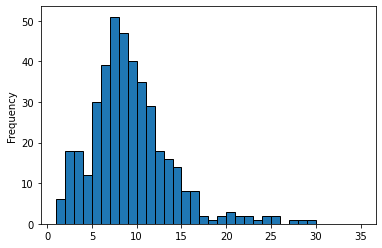

In [60]:
compiled['slr24'].plot.hist(bins=np.arange(1, 36, 1), edgecolor='k')

In [61]:
compiled = compiled.reset_index()
compiled['datetime_utc'] = [pd.to_datetime(t) + timedelta(hours=+8) for t in compiled['datetime_pst']]
compiled = compiled.set_index('datetime_utc').drop(columns='datetime_pst')
compiled

,maxT,swe24_mm,snow24_mm,slr24
datetime_utc,,,,
1971-11-25 08:00:00,0.000,62.230,0.00,0.000000
1971-11-26 08:00:00,-1.665,51.308,0.00,0.000000
1971-11-30 08:00:00,-2.775,109.220,93.98,8.604651
1971-12-02 08:00:00,-5.550,46.990,76.20,16.216216
1971-12-16 08:00:00,-4.995,53.848,43.18,8.018868
...,...,...,...,...
2019-02-04 08:00:00,-4.000,71.000,52.50,7.394366
2019-02-09 08:00:00,-5.000,75.000,11.00,1.466667
2019-02-15 08:00:00,-5.000,28.000,23.00,8.214286


In [62]:
compiled.to_pickle('~/mewessler/observations/clean/CSSL_1971_2019.pd')